In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../mnist_data/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = df.values
np.random.shuffle(data)
X = data[:, 1:].reshape(-1, 28, 28) / 255.0
Y = data[:, 0]

D = 28
M = 15

In [4]:
input_ = Input(shape=(D, D))  # size 28x28

# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_)  # output is N x D x 2M
x1 = GlobalMaxPooling1D()(x1)  # output is N x 2M

# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))
# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))

x2 = permutor(input_)
x2 = rnn2(x2)  # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2)  # output is N x 2M

# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2])  # output is N x 4M

# final dense layer
output = Dense(10, activation='softmax')(x)
model = Model(input_, output)

In [5]:
# testing
o = model.predict(X)
print(o.shape)

(42000, 10)


In [6]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.3)

Train on 29399 samples, validate on 12601 samples
Epoch 1/10
29399/29399 [==============================] - 7s 244us/step - loss: 0.8044 - acc: 0.7948 - val_loss: 0.3319 - val_acc: 0.9145
Epoch 2/10
29399/29399 [==============================] - 7s 236us/step - loss: 0.2516 - acc: 0.9306 - val_loss: 0.2067 - val_acc: 0.9429
Epoch 3/10
29399/29399 [==============================] - 7s 222us/step - loss: 0.1776 - acc: 0.9484 - val_loss: 0.1553 - val_acc: 0.9551
Epoch 4/10
29399/29399 [==============================] - 7s 224us/step - loss: 0.1413 - acc: 0.9582 - val_loss: 0.1347 - val_acc: 0.9608
Epoch 5/10
29399/29399 [==============================] - 7s 225us/step - loss: 0.1180 - acc: 0.9647 - val_loss: 0.1141 - val_acc: 0.9654
Epoch 6/10
29399/29399 [==============================] - 7s 230us/step - loss: 0.1021 - acc: 0.9684 - val_loss: 0.1144 - val_acc: 0.9656
Epoch 7/10
29399/29399 [==============================] - 7s 229us/step - loss: 0.0917 - acc: 0.9722 - val_loss: 0.0960 - 

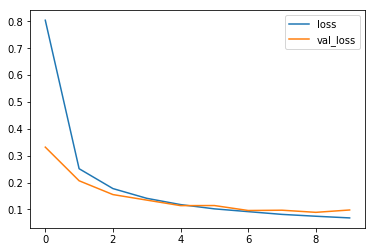

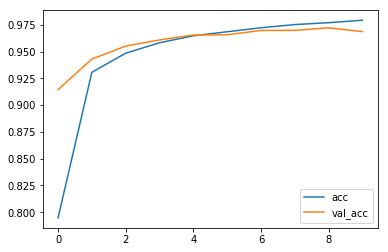

In [7]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()